# 필요 라이브러리

In [110]:
import os
import sys
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
sys.path.append('/project/kcure-08/lib/python3.7/site-packages')

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from catboost import CatBoostClassifier, Pool
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import lightgbm as lgb
import random
import sklearn
import shap


from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LinearRegression
# from sklearn.impute import SimpleImputer

In [111]:
print(os.getcwd()) # 현재 경로
# print(os.listdir(os.getcwd())) # 현재 경로 파일

os.chdir('/project/kcure-08/lib/python3.7/site-packages') # 현재 경로 변경(데이터 파일)
print(os.getcwd())
# print(os.listdir(os.getcwd()))

/project/kcure-08/src/1. Data/1. Colon
/project/kcure-08/lib/python3.7/site-packages


In [3]:
# ### 데이터 모든 행, 열 확인하기
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

---

# 1. 데이터 불러오기

In [112]:
print(os.getcwd()) # 현재 경로
# print(os.listdir(os.getcwd())) # 현재 경로 파일

os.chdir('/project/kcure-08/src/1. Data/1. Colon') # 현재 경로 변경(데이터 파일)
print(os.getcwd())
# print(os.listdir(os.getcwd()))

/project/kcure-08/lib/python3.7/site-packages
/project/kcure-08/src/1. Data/1. Colon


In [113]:
### 최종 재발과 재발없는 피험자 테이블 불러오기 ###
df_cs_cc_rec = pd.read_csv('./PP_csv/cs_cc_rec_fin.csv') # 암 재발 피험자
df_cs_cc_nrec = pd.read_csv('./PP_csv/cs_cc_nrec_fin.csv') # 암 재발이 없는 피험자 (대장암 진단 이후)

In [ ]:
##### 재발여부 상관없이 데이터 합치기 
df = pd.concat([df_cs_cc_rec, df_cs_cc_nrec], ignore_index = True)

---

# 2. 데이터 전처리하기

### 1. 불필요한 변수 제거 및 파생변수 생성
- [파생변수] : 재발시기(1년), 수술횟수, 요양식별기관(대,중도시), 흡연횟수, 알코올함량, 하루 알코올 섭취량 위험도, 신체활동량

In [116]:
df['TIME_OF_REC'].fillna('0 days', inplace = True) # NaN 값을 0 day 으로 처리 (재발없는 피험자)
df['TIME_OF_REC'] = df['TIME_OF_REC'].str.replace('days', '').astype(float).fillna(0).astype(int) # str(day)를 제거한뒤 int형으로 변환
df['TIME_OF_REC'] = pd.cut(df['TIME_OF_REC'],
                            bins = [-float('inf'), 0, 365, 730, 1095, 1460, 1825, float('inf')],
                            labels = [0, 1, 2, 3, 4, 5, 6],
                            include_lowest=True).astype(int) ## 1년단위로 범주화

In [ ]:
col_drop = ['TIME_OF_NREC_END', 'TIME_OF_REC_START', 'FDX'] # 날짜 데이터 삭제
df = df.drop(columns = col_drop)
df.head(1)

In [ ]:
col_drop = ['TIME_OF_REC'] # Feature 강하게 띄는 변수 제거
df = df.drop(columns = col_drop)
df.head(1)

### 2. Null 데이터 처리 (KNN Imputer) - 결측값 대치방법

In [119]:
### df 순서변경
'''현재 칼럼명 : ['SN_KEY', 'LABEL', 'RES', 'SOPR_Y_CNT', 'HGHT', 'WGHT',
       'BMI', 'WSTC', 'BP_SYS', 'BP_DIA', 'URN_PROT', 'HGB', 'FBS', 'SGOT',
       'SGPT', 'GGT', 'TG', 'HDL', 'LDL', 'TOT_CHOL', 'CRTN', 'GFR',
       'Q_FHX_ETC', 'Q_PHX_YN', 'Q_PHX_DX_STK', 'Q_PHX_DX_HTDZ',
       'Q_PHX_DX_HTN', 'Q_PHX_DX_DM', 'Q_PHX_DX_PTB', 'Q_PHX_DX_DLD',
       'Q_PHX_DX_ETC', 'Q_PHX_TX_STK', 'Q_PHX_TX_HTDZ', 'Q_PHX_TX_HTN',
       'Q_PHX_TX_DM', 'Q_PHX_TX_DLD', 'Q_PHX_TX_ETC', 'Q_SMK_YN',
       'Q_DAILY_DRK', 'Q_DRK_RISK', 'Q_PA_WGT_AVG', 'SEX', 'TCODE',
       'MCODE_GRP', 'GRADE', 'AGE', 'T_SIZE', 'EXT', 'LNPOS', 'METS', 'SSF1',
       'SSF8', 'SSF9', 'AJCC6_T', 'AJCC6_TEVAL', 'AJCC6_N', 'AJCC6_NEVAL',
       'AJCC6_M', 'AJCC6_MEVAL', 'AJCC6_STAGE', 'SS2000', 'WT_LSS',
       'WT_LSS_AMT', 'QC_PFHX_CST_YN', 'QC_PFHX_CST_I', 'QC_PFHX_CBR_YN',
       'QC_PFHX_CBR_I', 'QC_PFHX_CCR_YN', 'QC_PFHX_CCR_I', 'QC_PFHX_CLV_YN',
       'QC_PFHX_CLV_I', 'QC_PFHX_CCX_YN', 'QC_PFHX_CCX_I', 'QC_PFHX_ETC_YN',
       'QC_PFHX_ETC_I', 'QC_PHX_PU_YN', 'QC_PHX_ATGS_YN', 'QC_PHX_INMT_YN',
       'QC_PHX_GPO_YN', 'QC_PHX_ST_ETC', 'QC_PHX_CRA_YN', 'QC_PHX_CD_YN',
       'QC_PHX_HMR_YN', 'QC_PHX_LV_YN', 'QC_PHX_CHB_YN', 'QC_PHX_CHC_YN']'''

df = df[['SN_KEY', 'LABEL','SEX', 'AGE', 'RES', 'SOPR_Y_CNT', 'HGHT', 'WGHT',
       'BMI', 'WSTC', 'BP_SYS', 'BP_DIA', 'URN_PROT', 'HGB', 'FBS', 'SGOT',
       'SGPT', 'GGT', 'TG', 'HDL', 'LDL', 'TOT_CHOL', 'CRTN', 'GFR', 'TCODE',
       'MCODE_GRP', 'GRADE',  'T_SIZE', 'EXT', 'LNPOS', 'METS', 'SSF1',
       'SSF8', 'SSF9', 'AJCC6_T', 'AJCC6_TEVAL', 'AJCC6_N', 'AJCC6_NEVAL',
       'AJCC6_M', 'AJCC6_MEVAL', 'AJCC6_STAGE', 'SS2000', 'WT_LSS', 'Q_SMK_YN',
       'Q_DAILY_DRK', 'Q_DRK_RISK', 'Q_PA_WGT_AVG',
       'Q_FHX_ETC', 'Q_PHX_YN', 'Q_PHX_DX_STK', 'Q_PHX_DX_HTDZ',
       'Q_PHX_DX_HTN', 'Q_PHX_DX_DM', 'Q_PHX_DX_PTB', 'Q_PHX_DX_DLD',
       'Q_PHX_DX_ETC', 'Q_PHX_TX_STK', 'Q_PHX_TX_HTDZ', 'Q_PHX_TX_HTN',
       'Q_PHX_TX_DM', 'Q_PHX_TX_DLD', 'Q_PHX_TX_ETC',
       'WT_LSS_AMT', 'QC_PFHX_CST_YN', 'QC_PFHX_CST_I', 'QC_PFHX_CBR_YN',
       'QC_PFHX_CBR_I', 'QC_PFHX_CCR_YN', 'QC_PFHX_CCR_I', 'QC_PFHX_CLV_YN',
       'QC_PFHX_CLV_I', 'QC_PFHX_CCX_YN', 'QC_PFHX_CCX_I', 'QC_PFHX_ETC_YN',
       'QC_PFHX_ETC_I', 'QC_PHX_PU_YN', 'QC_PHX_ATGS_YN', 'QC_PHX_INMT_YN',
       'QC_PHX_GPO_YN', 'QC_PHX_ST_ETC', 'QC_PHX_CRA_YN', 'QC_PHX_CD_YN',
       'QC_PHX_HMR_YN', 'QC_PHX_LV_YN', 'QC_PHX_CHB_YN', 'QC_PHX_CHC_YN']] ### 칼럼명 변경

df.columns = ['SN_KEY', 'LABEL','SEX', 'AGE', 'CL_CD', 'SOPR_Y_CNT', 'HGHT', 'WGHT',
       'BMI', 'WSTC', 'BP_SYS', 'BP_DIA', 'URN_PROT', 'HGB', 'FBS', 'SGOT',
       'SGPT', 'GGT', 'TG', 'HDL', 'LDL', 'TOT_CHOL', 'CRTN', 'GFR', 'TCODE',
       'MCODE_GRP', 'GRADE',  'T_SIZE', 'EXT', 'LNPOS', 'METS', 'SSF1',
       'SSF8', 'SSF9', 'AJCC6_T', 'AJCC6_TEVAL', 'AJCC6_N', 'AJCC6_NEVAL',
       'AJCC6_M', 'AJCC6_MEVAL', 'AJCC6_STAGE', 'SS2000', 'WT_LSS', 'Q_SMK_YN',
       'Q_DAILY_DRK', 'Q_DRK_RISK', 'Q_PA_WGT_AVG',
       'Q_FHX_ETC', 'Q_PHX_YN', 'Q_PHX_DX_STK', 'Q_PHX_DX_HTDZ',
       'Q_PHX_DX_HTN', 'Q_PHX_DX_DM', 'Q_PHX_DX_PTB', 'Q_PHX_DX_DLD',
       'Q_PHX_DX_ETC', 'Q_PHX_TX_STK', 'Q_PHX_TX_HTDZ', 'Q_PHX_TX_HTN',
       'Q_PHX_TX_DM', 'Q_PHX_TX_DLD', 'Q_PHX_TX_ETC',
       'WT_LSS_AMT', 'QC_PFHX_CST_YN', 'QC_PFHX_CST_I', 'QC_PFHX_CBR_YN',
       'QC_PFHX_CBR_I', 'QC_PFHX_CCR_YN', 'QC_PFHX_CCR_I', 'QC_PFHX_CLV_YN',
       'QC_PFHX_CLV_I', 'QC_PFHX_CCX_YN', 'QC_PFHX_CCX_I', 'QC_PFHX_ETC_YN',
       'QC_PFHX_ETC_I', 'QC_PHX_PU_YN', 'QC_PHX_ATGS_YN', 'QC_PHX_INMT_YN',
       'QC_PHX_GPO_YN', 'QC_PHX_ST_ETC', 'QC_PHX_CRA_YN', 'QC_PHX_CD_YN',
       'QC_PHX_HMR_YN', 'QC_PHX_LV_YN', 'QC_PHX_CHB_YN', 'QC_PHX_CHC_YN'] ###  RES --> CL_CD

In [121]:
df.describe()

,LABEL,SEX,AGE,CL_CD,SOPR_Y_CNT,HGHT,WGHT,BMI,WSTC,BP_SYS,BP_DIA,URN_PROT,HGB,FBS,SGOT,SGPT,GGT,TG,HDL,LDL,TOT_CHOL,CRTN,GFR,TCODE,MCODE_GRP,GRADE,T_SIZE,EXT,LNPOS,METS,SSF1,SSF8,SSF9,AJCC6_T,AJCC6_TEVAL,AJCC6_N,AJCC6_NEVAL,AJCC6_M,AJCC6_MEVAL,AJCC6_STAGE,SS2000,WT_LSS,Q_SMK_YN,Q_DAILY_DRK,Q_DRK_RISK,Q_PA_WGT_AVG,Q_FHX_ETC,Q_PHX_YN,Q_PHX_DX_STK,Q_PHX_DX_HTDZ,Q_PHX_DX_HTN,Q_PHX_DX_DM,Q_PHX_DX_PTB,Q_PHX_DX_DLD,Q_PHX_DX_ETC,Q_PHX_TX_STK,Q_PHX_TX_HTDZ,Q_PHX_TX_HTN,Q_PHX_TX_DM,Q_PHX_TX_DLD,Q_PHX_TX_ETC,WT_LSS_AMT,QC_PFHX_CST_YN,QC_PFHX_CST_I,QC_PFHX_CBR_YN,QC_PFHX_CBR_I,QC_PFHX_CCR_YN,QC_PFHX_CCR_I,QC_PFHX_CLV_YN,QC_PFHX_CLV_I,QC_PFHX_CCX_YN,QC_PFHX_CCX_I,QC_PFHX_ETC_YN,QC_PFHX_ETC_I,QC_PHX_PU_YN,QC_PHX_ATGS_YN,QC_PHX_INMT_YN,QC_PHX_GPO_YN,QC_PHX_ST_ETC,QC_PHX_CRA_YN,QC_PHX_CD_YN,QC_PHX_HMR_YN,QC_PHX_LV_YN,QC_PHX_CHB_YN,QC_PHX_CHC_YN
count,21654.000000,21654.000000,21654.000000,21654.000000,21654.000000,16464.000000,16464.000000,16464.000000,16465.000000,16424.000000,16424.000000,16263.000000,16422.000000,16424.000000,16424.000000,16423.000000,16424.000000,15797.000000,15797.000000,15711.000000,15797.000000,16424.000000,16274.000000,21654.000000,21654.000000,21654.000000,18333.000000,20413.00000,16106.000000,21214.000000,18653.000000,17643.000000,9588.000000,20413.000000,21654.000000,20718.000000,21654.000000,21214.000000,21654.000000,21654.000000,21126.000000,12685.000000,16464.000000,16020.000000,16461.000000,16455.000000,10274.000000,16470.000000,9616.000000,9766.000000,12268.000000,10643.000000,9553.000000,9859.000000,10383.000000,325.000000,731.000000,5918.000000,2461.000000,847.000000,2437.000000,341.000000,12628.000000,816.000000,12581.000000,179.000000,12631.000000,1270.000000,12604.000000,318.000000,12583.000000,175.000000,12236.000000,836.000000,11819.000000,11906.000000,11515.000000,11567.000000,11875.000000,11974.000000,11742.000000,12187.000000,12488.000000,12412.000000,12408.000000
mean,0.008959,1.399002,65.254272,0.250115,2.583957,158.429908,58.859937,23.764699,78.664440,127.593156,77.758220,1.138966,13.673201,107.294508,26.751766,24.018450,43.474976,142.102678,52.550358,114.739164,194.648224,0.942730,84.689197,6.359010,1.071349,1.167683,44.103638,386.19179,0.419657,0.184265,0.399560,0.243836,0.389341,1.677705,0.775884,0.635438,0.691466,0.184265,0.042117,3.095133,1.707043,1.027828,1.661139,8.927135,0.162566,5.932726,0.211991,1.542441,0.036294,0.076797,0.490871,0.236306,0.028159,0.089563,0.253395,0.910769,0.956224,0.977695,0.968306,0.933884,0.780057,5.917889,0.122506,1.186275,0.048406,1.324022,0.140369,1.762992,0.065693,1.160377,0.048081,1.285714,0.117195,1.340909,1.062273,1.077020,1.003213,1.013832,1.068211,1.050693,1.000085,1.082629,1.019619,1.005076,1.003385
std,0.094230,0.489705,11.457241,0.433089,2.190621,7.826061,10.986955,2.797727,8.394326,15.780537,10.222749,0.566343,1.870758,33.307266,19.537169,21.661226,65.598376,97.489598,16.614225,44.905434,43.220004,1.143704,27.588691,3.390849,0.453783,1.133905,31.162250,146.13074,0.493518,0.387709,0.489821,0.429407,0.487626,0.965519,0.454322,0.760931,0.485778,0.387709,0.215073,2.696060,1.242824,0.164487,0.806811,17.270969,0.595292,8.495360,0.408739,0.498211,0.187030,0.266283,0.499937,0.424832,0.165435,0.285569,0.434976,0.285516,0.204736,0.147686,0.175221,0.248631,0.414292,2.512147,0.376035,0.389567,0.276177,0.469321,0.388281,0.425415,0.305158,0.367534,0.277359,0.453050,0.368114,0.474299,0.241660,0.266634,0.056596,0.116800,0.252117,0.219380,0.009228,0.275332,0.138692,0.071066,0.058084
min,0.000000,1.000000,29.000000,0.000000,0.000000,150.000000,40.000000,20.000000,60.000000,70.000000,40.000000,1.000000,1.800000,45.000000,4.000000,3.000000,1.000000,18.000000,6.000000,1.000000,69.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,130.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0

### 학습/검증/시험 데이터 분리

In [82]:
### Train, Test 분할 8: 2
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='LABEL'), df['LABEL'], 
                                                    test_size=0.2, shuffle=True, stratify=df['LABEL'], random_state = 42)


## Train, valid 분할 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                    test_size=0.25, shuffle=True, stratify=y_train, random_state = 42)

In [83]:
X_train_id = X_train.pop('SN_KEY') ### key값 따로저장
X_test_id = X_test.pop('SN_KEY')
X_val_id = X_val.pop('SN_KEY')

In [99]:
imputer = KNNImputer(n_neighbors=2)
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns = X_train.columns)
X_val_imputed =  pd.DataFrame(imputer.transform(X_val), columns = X_val.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns = X_test.columns)

### 3. 이상치 제거 IQR

In [32]:
# def remove_outlier_iqr(df, columns, threshold=1.5):
#     df_no_outliers = df.copy()
    
#     for col in columns:
#         Q1 = df_no_outliers[col].quantile(0.25)
#         Q3 = df_no_outliers[col].quantile(0.75)
#         IQR = Q3 - Q1
        
#         lower_bound = Q1 - threshold * IQR
#         upper_bound = Q3 + threshold * IQR
        
#         df_no_outliers = df_no_outliers[(df_no_outliers[col] >= lower_bound) & df_no_outliers[col] <= upper_bound]
        
#     return df_no_outliers

# columns_to_remove_outliers = ['SEX', 'AGE', 'CL_CD', 'SOPR_Y_CNT', 'HGHT', 'WGHT', 'BMI', 'WSTC',
#        'BP_SYS', 'BP_DIA', 'URN_PROT', 'HGB', 'FBS', 'SGOT', 'SGPT', 'GGT',
#        'TG', 'HDL', 'LDL', 'TOT_CHOL', 'CRTN', 'GFR', 'TCODE', 'MCODE_GRP',
#        'GRADE', 'T_SIZE', 'EXT', 'LNPOS', 'METS', 'SSF1', 'SSF8', 'SSF9',
#        'AJCC6_T', 'AJCC6_TEVAL', 'AJCC6_N', 'AJCC6_NEVAL', 'AJCC6_M',
#        'AJCC6_MEVAL', 'AJCC6_STAGE', 'SS2000', 'WT_LSS', 'Q_SMK_YN',
#        'Q_DAILY_DRK', 'Q_DRK_RISK', 'Q_PA_WGT_AVG', 'Q_FHX_ETC', 'Q_PHX_YN',
#        'Q_PHX_DX_STK', 'Q_PHX_DX_HTDZ', 'Q_PHX_DX_HTN', 'Q_PHX_DX_DM',
#        'Q_PHX_DX_PTB', 'Q_PHX_DX_DLD', 'Q_PHX_DX_ETC', 'Q_PHX_TX_STK',
#        'Q_PHX_TX_HTDZ', 'Q_PHX_TX_HTN', 'Q_PHX_TX_DM', 'Q_PHX_TX_DLD',
#        'Q_PHX_TX_ETC', 'WT_LSS_AMT', 'QC_PFHX_CST_YN', 'QC_PFHX_CST_I',
#        'QC_PFHX_CBR_YN', 'QC_PFHX_CBR_I', 'QC_PFHX_CCR_YN', 'QC_PFHX_CCR_I',
#        'QC_PFHX_CLV_YN', 'QC_PFHX_CLV_I', 'QC_PFHX_CCX_YN', 'QC_PFHX_CCX_I',
#        'QC_PFHX_ETC_YN', 'QC_PFHX_ETC_I', 'QC_PHX_PU_YN', 'QC_PHX_ATGS_YN',
#        'QC_PHX_INMT_YN', 'QC_PHX_GPO_YN', 'QC_PHX_ST_ETC', 'QC_PHX_CRA_YN',
#        'QC_PHX_CD_YN', 'QC_PHX_HMR_YN', 'QC_PHX_LV_YN', 'QC_PHX_CHB_YN',
#        'QC_PHX_CHC_YN']

# df_no_outliers = remove_outlier_iqr(X_train_imputed, columns_to_remove_outliers)
# print("이상치 제거 전: ")
# print(df.describe())

# print("\n 이상치 제거 후: ")
# print(df_no_outliers.describe())

이상치 제거 전: 
              LABEL           SEX           AGE         CL_CD    SOPR_Y_CNT  \
count  21654.000000  21654.000000  21654.000000  21654.000000  21654.000000   
mean       0.008959      1.399002     65.254272      0.250115      2.583957   
std        0.094230      0.489705     11.457241      0.433089      2.190621   
min        0.000000      1.000000     29.000000      0.000000      0.000000   
25%        0.000000      1.000000     57.000000      0.000000      1.000000   
50%        0.000000      1.000000     66.000000      0.000000      2.000000   
75%        0.000000      2.000000     75.000000      1.000000      3.000000   
max        1.000000      2.000000     80.000000      1.000000     55.000000   

               HGHT          WGHT           BMI          WSTC        BP_SYS  \
count  16464.000000  16464.000000  16464.000000  16465.000000  16424.000000   
mean     158.429908     58.859937     23.764699     78.664440    127.593156   
std        7.826061     10.986955      2

###  4. Label encoding (이전에 이미 처리 작업진행)

###  5. 불균형 클래스 처리

<AxesSubplot:>

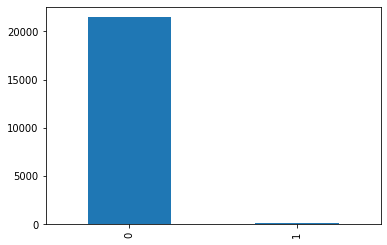

In [122]:
df['LABEL'].value_counts().plot(kind ='bar')

In [123]:
smote = SMOTE(random_state = 42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_imputed, y_train)

<AxesSubplot:>

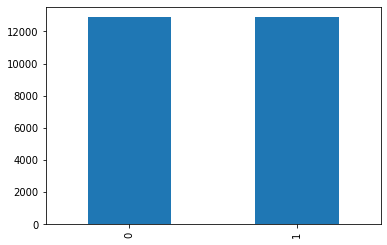

In [124]:
y_train_smote.value_counts().plot(kind ='bar')

# 3. 모델링

In [125]:
result = pd.DataFrame([], columns = ['acc', 'recall', 'precision', 'F1-score'])

In [104]:
## 성능 지표 계산

def result_view(model_name, pred, actual):
    acc = round(accuracy_score(actual, pred), 3)
    precision = round(precision_score(actual, pred), 3)
    recall = round(recall_score(actual, pred), 3)
    f1 = round(f1_score(actual, pred), 3)
    
    result.loc[model_name]=(acc, recall, precision, f1)
    result.sort_values(by='acc', inplace = True, ascending = True)
    
    print(result)
    plt.figure(figsize=(8,5))
    for idx in result.index:
        x_values = result.columns
        y_values = result.loc[idx]
        plt.plot(x_values, y_values)
        plt.annotate(text=round(result.loc[idx, 'acc'], 3), xy=(0, result.loc[idx, 'acc']),
                    xytext=(0, result.loc[idx, 'acc']), ha='center', fontsize=14)
        
        plt.annotate(text=round(result.loc[idx, 'recall'], 3), xy=(1, result.loc[idx, 'recall']),
                    xytext=(1, result.loc[idx, 'recall']), ha='center', fontsize=14)
        
        plt.annotate(text=round(result.loc[idx, 'precision'], 3), xy=(2, result.loc[idx, 'precision']),
                    xytext=(2, result.loc[idx, 'precision']), ha='center', fontsize=14)
        
        plt.annotate(text=round(result.loc[idx, 'F1-score'], 3), xy=(3, result.loc[idx, 'F1-score']),
                    xytext=(3, result.loc[idx, 'F1-score']), ha='center', fontsize=14)              

### 1. Logistic Regression

In [105]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform
param_dist = {
    'penalty': ['l1', 'l2'],
    'C': uniform(loc=0, scale=4)
}

In [94]:
model_lr = LogisticRegression()
random_search_lr = RandomizedSearchCV(model_lr, param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=42)
random_search_lr.fit(X_train_smote, y_train_smote)

RandomizedSearchCV(cv=5, estimator=LogisticRegression(),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f64cb07e0d0>,
                                        'penalty': ['l1', 'l2']},
                   random_state=42, scoring='accuracy')

In [106]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform
param_dist = {
    'penalty': ['l1', 'l2'],
    'C': uniform(loc=0, scale=4)
}

model_lr = LogisticRegression()
random_search_lr = RandomizedSearchCV(model_lr, param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=42)
random_search_lr.fit(X_train_smote, y_train_smote)

print("최적 하이퍼파라미터:", random_search_lr.best_params_)

y_pred = random_search_lr.predict(X_test_imputed)

acc = accuracy_score(y_test, y_pred)
print(f'정확도: {acc}')

y_pred_probs = random_search_lr.predict_proba(X_test_imputed)
y_pred = random_search_lr.predict(X_test_imputed)

thd = 0.6 # 예측 확률이 0.6 이상이면 고위험군으로 분류

y_pred_high_risk = (y_pred_probs[:, 1] >= thd).astype(int)

print("confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("고위험군 수:", sum(y_pred_high_risk == 1))
print("중위험군 수:", sum((y_pred_high_risk == 0) & (y_pred == 1)))
print("저위험군 수:", sum((y_pred_high_risk == 0) & (y_pred == 0)))

최적 하이퍼파라미터: {'C': 0.7337391594646552, 'penalty': 'l2'}
정확도: 0.7201570076194874
confusion Matrix:
[[3091 1201]
 [  11   28]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.72      0.84      4292
           1       0.02      0.72      0.04        39

    accuracy                           0.72      4331
   macro avg       0.51      0.72      0.44      4331
weighted avg       0.99      0.72      0.83      4331

고위험군 수: 728
중위험군 수: 501
저위험군 수: 3102


In [61]:
print("최적 하이퍼파라미터:", random_search_lr.best_params_)

최적 하이퍼파라미터: {'C': 0.7337391594646552, 'penalty': 'l2'}


In [62]:
y_pred = random_search_lr.predict(X_test_imputed)

acc = accuracy_score(y_test, y_pred)
print(f'정확도: {acc}')

정확도: 0.7520203186331101


In [64]:
y_pred_probs = random_search_lr.predict_proba(X_test_imputed)
y_pred = random_search_lr.predict(X_test_imputed)

thd = 0.6 # 예측 확률이 0.6 이상이면 고위험군으로 분류

y_pred_high_risk = (y_pred_probs[:, 1] >= thd).astype(int)

print("confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

confusion Matrix:
[[3231 1061]
 [  13   26]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86      4292
           1       0.02      0.67      0.05        39

    accuracy                           0.75      4331
   macro avg       0.51      0.71      0.45      4331
weighted avg       0.99      0.75      0.85      4331



In [65]:
print("고위험군 수:", sum(y_pred_high_risk == 1))
print("중위험군 수:", sum((y_pred_high_risk == 0) & (y_pred == 1)))
print("저위험군 수:", sum((y_pred_high_risk == 0) & (y_pred == 0)))

고위험군 수: 693
중위험군 수: 394
저위험군 수: 3244


In [42]:
pred_lr = model_lr.predict(X_test_imputed)

                       acc  recall  precision  F1-score
Logistic Regression  0.752   0.667      0.024     0.046


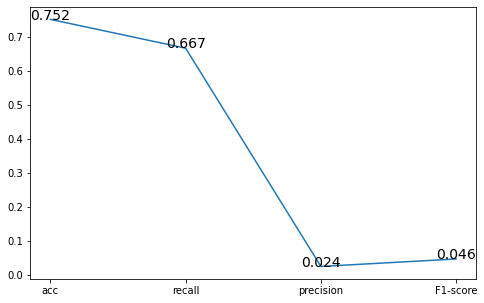

In [63]:
result_view('Logistic Regression', y_pred, y_test)

-----

In [44]:
from sklearn.metrics import classification_report, confusion_matrix

In [46]:
y_pred_probs = model_lr.predict_proba(X_test_imputed)
y_pred = model_lr.predict(X_test_imputed)

thd = 0.6 # 예측 확률이 0.6 이상이면 고위험군으로 분류

y_pred_high_risk = (y_pred_probs[:, 1] >= thd).astype(int)

print("confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

confusion Matrix:
[[3241 1051]
 [  14   25]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.76      0.86      4292
           1       0.02      0.64      0.04        39

    accuracy                           0.75      4331
   macro avg       0.51      0.70      0.45      4331
weighted avg       0.99      0.75      0.85      4331



In [47]:
print("고위험군 수:", sum(y_pred_high_risk == 1))
print("중위험군 수:", sum((y_pred_high_risk == 0) & (y_pred == 1)))
print("저위험군 수:", sum((y_pred_high_risk == 0) & (y_pred == 0)))

고위험군 수: 673
중위험군 수: 403
저위험군 수: 3255


### 2. KNN
- 94%
- 고위험군 수: 217
- 중위험군 수: 0
- 저위험군 수: 4114

In [21]:
from scipy.stats import randint

In [68]:
param_dist = {
    'n_neighbors': randint(1,20),
    'p': [1, 2]
}

In [69]:
model_knn = KNeighborsClassifier()
random_search_knn = RandomizedSearchCV(model_knn, param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=42)
random_search_knn.fit(X_train_smote, y_train_smote)

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(),
                   param_distributions={'n_neighbors': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fda176b4190>,
                                        'p': [1, 2]},
                   random_state=42, scoring='accuracy')

In [74]:
print("최적 하이퍼파라미터:", random_search_knn.best_params_)

최적 하이퍼파라미터: {'n_neighbors': 2, 'p': 2}


In [71]:
y_pred = random_search_knn.predict(X_test_imputed)

acc = accuracy_score(y_test, y_pred)
print(f'정확도: {acc}')

정확도: 0.9436619718309859


In [72]:
y_pred_probs = random_search_knn.predict_proba(X_test_imputed)
y_pred = random_search_knn.predict(X_test_imputed)

thd = 0.6 # 예측 확률이 0.6 이상이면 고위험군으로 분류

y_pred_high_risk = (y_pred_probs[:, 1] >= thd).astype(int)

print("confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

confusion Matrix:
[[4081  211]
 [  33    6]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      4292
           1       0.03      0.15      0.05        39

    accuracy                           0.94      4331
   macro avg       0.51      0.55      0.51      4331
weighted avg       0.98      0.94      0.96      4331



In [73]:
print("고위험군 수:", sum(y_pred_high_risk == 1))
print("중위험군 수:", sum((y_pred_high_risk == 0) & (y_pred == 1)))
print("저위험군 수:", sum((y_pred_high_risk == 0) & (y_pred == 0)))

고위험군 수: 217
중위험군 수: 0
저위험군 수: 4114


In [51]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train_smote, y_train_smote)

KNeighborsClassifier()

                       acc  recall  precision  F1-score
Logistic Regression  0.754   0.641      0.023     0.045
KNN                  0.873   0.231      0.017     0.032


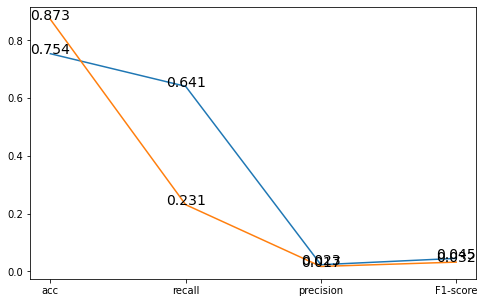

In [26]:
pred_knn = model_knn.predict(X_test_imputed)
result_view('KNN', pred_knn, y_test)

### 3. SVM

In [ ]:
param_dist = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

model_svm =  SVC(random_state = 42)
random_search_svm = RandomizedSearchCV(model_svm, param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=42)
random_search_svm.fit(X_train_smote, y_train_smote)


print("최적 하이퍼파라미터:", random_search_svm.best_params_)

y_pred = random_search_svm.predict(X_test_imputed)

acc = accuracy_score(y_test, y_pred)
print(f'정확도: {acc}')

y_pred_probs = random_search_svm.predict_proba(X_test_imputed)
y_pred = random_search_svm.predict(X_test_imputed)

thd = 0.6 # 예측 확률이 0.6 이상이면 고위험군으로 분류

y_pred_high_risk = (y_pred_probs[:, 1] >= thd).astype(int)

print("confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("고위험군 수:", sum(y_pred_high_risk == 1))
print("중위험군 수:", sum((y_pred_high_risk == 0) & (y_pred == 1)))
print("저위험군 수:", sum((y_pred_high_risk == 0) & (y_pred == 0)))

---

In [27]:
model_svm = SVC(random_state = 42)
model_svm.fit(X_train_smote, y_train_smote)

SVC(random_state=42)

                       acc  recall  precision  F1-score
SVM                  0.681   0.385      0.011     0.021
Logistic Regression  0.754   0.641      0.023     0.045
KNN                  0.873   0.231      0.017     0.032


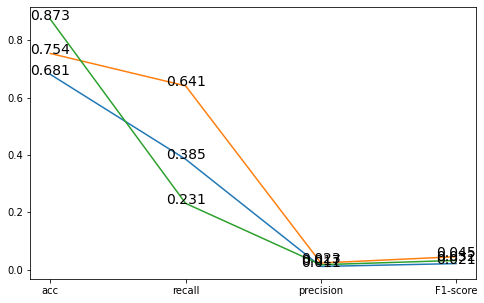

In [28]:
pred_svm = model_svm.predict(X_test_imputed)
result_view('SVM', pred_svm, y_test)

### 4. 의사결정나무

In [ ]:
param_dist = {
    'max_depth' : [None, 10, 20, 30, 40, 50]
    'min_sample_split' : randint(2,11),
    'min_samples_leaf' : randint(1,11),
    'criterion': ['gini', 'entropy']
}

model_dt = DecisionTreeClassifier()
random_search_dt = RandomizedSearchCV(model_dt, param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=42)
random_search_dt.fit(X_train_smote, y_train_smote)


print("최적 하이퍼파라미터:", random_search_dt.best_params_)

y_pred = random_search_dt.predict(X_test_imputed)

acc = accuracy_score(y_test, y_pred)
print(f'정확도: {acc}')

y_pred_probs = random_search_dt.predict_proba(X_test_imputed)
y_pred = random_search_dt.predict(X_test_imputed)

thd = 0.6 # 예측 확률이 0.6 이상이면 고위험군으로 분류

y_pred_high_risk = (y_pred_probs[:, 1] >= thd).astype(int)

print("confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("고위험군 수:", sum(y_pred_high_risk == 1))
print("중위험군 수:", sum((y_pred_high_risk == 0) & (y_pred == 1)))
print("저위험군 수:", sum((y_pred_high_risk == 0) & (y_pred == 0)))

In [29]:
model_dt = DecisionTreeClassifier(min_samples_split=2,
                                 min_samples_leaf = 1,
                                 max_features = None,
                                 max_depth = 5,
                                 max_leaf_nodes = None,
                                 random_state = 21
                                 )
model_dt.fit(X_train_smote, y_train_smote)

DecisionTreeClassifier(max_depth=5, random_state=21)

                       acc  recall  precision  F1-score
SVM                  0.681   0.385      0.011     0.021
Logistic Regression  0.754   0.641      0.023     0.045
KNN                  0.873   0.231      0.017     0.032
Decision Tree        0.897   0.359      0.032     0.059


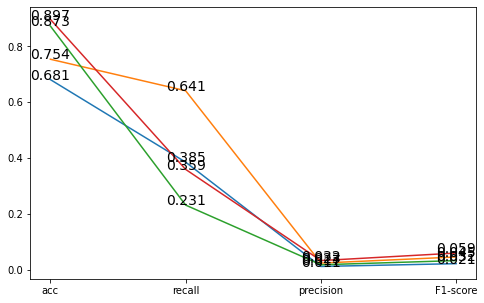

In [30]:
pred_dt = model_dt.predict(X_test_imputed)
result_view('Decision Tree', pred_dt, y_test)

### 5. 랜덤 포레스트

In [108]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform
from sklearn.metrics import classification_report, confusion_matrix

param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth' : [None, 10, 20, 30, 40, 50],
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 11),
    'criterion' : ['gini', 'entropy']
}

model_rf = RandomForestClassifier()
random_search_rf = RandomizedSearchCV(model_rf, param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=42)
random_search_rf.fit(X_train_smote, y_train_smote)


print("최적 하이퍼파라미터:", random_search_rf.best_params_)

y_pred = random_search_rf.predict(X_test_imputed)

acc = accuracy_score(y_test, y_pred)
print(f'정확도: {acc}')

y_pred_probs = random_search_rf.predict_proba(X_test_imputed)
y_pred = random_search_rf.predict(X_test_imputed)

thd = 0.6 # 예측 확률이 0.6 이상이면 고위험군으로 분류

y_pred_high_risk = (y_pred_probs[:, 1] >= thd).astype(int)

최적 하이퍼파라미터: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 6, 'min_samples_split': 6, 'n_estimators': 100}
정확도: 0.9898406834449319


In [109]:
print("confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("고위험군 수:", sum(y_pred_high_risk == 1))
print("중위험군 수:", sum((y_pred_high_risk == 0) & (y_pred == 1)))
print("저위험군 수:", sum((y_pred_high_risk == 0) & (y_pred == 0)))

confusion Matrix:
[[4287    5]
 [  39    0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4292
           1       0.00      0.00      0.00        39

    accuracy                           0.99      4331
   macro avg       0.50      0.50      0.50      4331
weighted avg       0.98      0.99      0.99      4331

고위험군 수: 1
중위험군 수: 4
저위험군 수: 4326


In [31]:
model_rf = RandomForestClassifier(n_jobs=-1, n_estimators=100,
                                 min_samples_split = 2,
                                 min_samples_leaf = 1,
                                 max_features = 'auto',
                                 max_depth = None,
                                 max_leaf_nodes=None,
                                  random_state = 42)
model_rf.fit(X_train_smote, y_train_smote)

RandomForestClassifier(n_jobs=-1, random_state=42)

                       acc  recall  precision  F1-score
SVM                  0.681   0.385      0.011     0.021
Logistic Regression  0.754   0.641      0.023     0.045
KNN                  0.873   0.231      0.017     0.032
Decision Tree        0.897   0.359      0.032     0.059
Random Forest        0.991   0.000      0.000     0.000


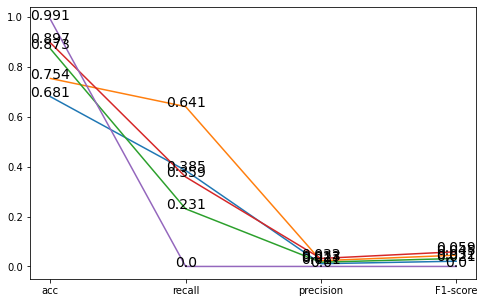

In [32]:
pred_rf = model_rf.predict(X_test_imputed)
result_view('Random Forest', pred_rf, y_test)

In [33]:
print(model_rf.feature_importances_, '\n')

[2.35692397e-02 8.28002649e-03 5.98888639e-02 7.33006357e-02
 1.65408957e-02 1.31353195e-02 5.68160995e-03 1.04903024e-02
 5.21548561e-03 6.09935918e-03 6.26642520e-03 3.84632074e-03
 4.86038068e-03 3.98373986e-03 5.96180796e-03 6.65302870e-03
 7.27540328e-03 4.51587310e-03 6.44788244e-03 7.17886176e-03
 1.05973213e-02 7.76762164e-03 9.86806354e-03 2.66460969e-03
 1.07129291e-02 7.76503244e-03 1.16236131e-02 2.01267209e-02
 7.68890823e-03 5.72034313e-02 4.56662338e-02 1.38456236e-02
 5.99443220e-03 1.65690386e-02 2.17348364e-02 3.74452044e-02
 8.36074758e-03 1.30319353e-03 1.54466677e-02 1.28564096e-02
 2.22753735e-03 2.56304116e-02 4.81339065e-03 4.13490310e-03
 3.52105729e-03 8.40630997e-03 1.67088972e-02 3.94399257e-03
 5.20704821e-03 1.46589844e-02 1.41720789e-02 1.29899161e-03
 5.67612593e-03 1.71549967e-02 8.08031285e-03 3.06323665e-03
 5.52633885e-04 2.28801880e-03 4.75535883e-03 8.17487133e-03
 9.01436005e-03 1.08407289e-02 1.03559110e-02 3.19059081e-03
 1.37945635e-02 2.547276

In [34]:
ser = pd.Series(model_rf.feature_importances_, index=X_train.columns)
top15 = ser.sort_values(ascending = False)[:15]
print(top15)

SOPR_Y_CNT        0.073301
CL_CD             0.059889
SSF1              0.057203
SSF8              0.045666
QC_PFHX_CCR_I     0.039202
AJCC6_NEVAL       0.037445
QC_PHX_CRA_YN     0.036703
QC_PFHX_CLV_I     0.031690
Q_SMK_YN          0.025630
QC_PFHX_CCR_YN    0.025473
SEX               0.023569
AJCC6_N           0.021735
LNPOS             0.020127
Q_PHX_DX_ETC      0.017155
Q_PHX_YN          0.016709
dtype: float64


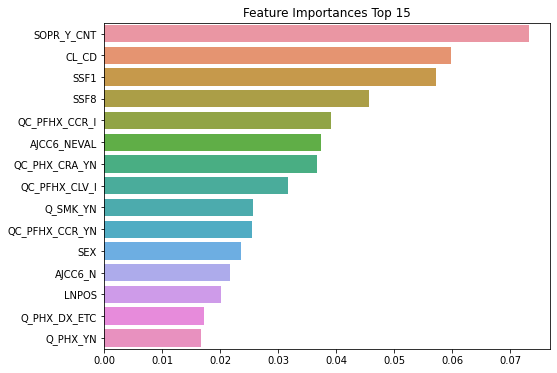

In [35]:
import seaborn as sns

plt.figure(figsize = (8,6))
plt.title('Feature Importances Top 15')
sns.barplot(x = top15, y = top15.index)
plt.show()

In [ ]:
['SOPR_Y_CNT', 'CL_CD', 'SSF1', 'SSF8', 'QC_PFHX_CCR_I', 'AJCC6_NEVAL', 'QC_PHX_CRA_YN', QC_PFHX_CLV_I, Q_SMK_YN, QC_PFHX_CCR_YN, SEX, AJCC6_N, LNPOS, Q_PHX_DX_ETC, Q_PHX_YN]

### 6. XGBoost

In [36]:
model_xgb = xgb.XGBClassifier(learning_rate=0.1,
                             n_jobs = -1,
                             n_estimators = 500,
                             random_state = 21)

In [37]:
start= time.time
eval_set = [(X_val_imputed, y_val)]

In [38]:
model_xgb.fit(X_train_smote, y_train_smote, early_stopping_rounds=10,
             eval_metric = "logloss", eval_set=eval_set, verbose=True)

# (time.time()-start)/60

[0]	validation_0-logloss:0.61951
[1]	validation_0-logloss:0.55859
[2]	validation_0-logloss:0.50645
[3]	validation_0-logloss:0.46191
[4]	validation_0-logloss:0.42367
[5]	validation_0-logloss:0.38759
[6]	validation_0-logloss:0.35452
[7]	validation_0-logloss:0.32791
[8]	validation_0-logloss:0.30281
[9]	validation_0-logloss:0.28054
[10]	validation_0-logloss:0.25978
[11]	validation_0-logloss:0.24291
[12]	validation_0-logloss:0.22440
[13]	validation_0-logloss:0.20909
[14]	validation_0-logloss:0.19650
[15]	validation_0-logloss:0.18502
[16]	validation_0-logloss:0.17344
[17]	validation_0-logloss:0.16308
[18]	validation_0-logloss:0.15427
[19]	validation_0-logloss:0.14553
[20]	validation_0-logloss:0.13691
[21]	validation_0-logloss:0.12890
[22]	validation_0-logloss:0.12196
[23]	validation_0-logloss:0.11556
[24]	validation_0-logloss:0.10983
[25]	validation_0-logloss:0.10436
[26]	validation_0-logloss:0.09925
[27]	validation_0-logloss:0.09518
[28]	validation_0-logloss:0.09074
[29]	validation_0-loglos

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=500,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=21,
              reg_alpha=0, reg_lambda=1, ...)

                       acc  recall  precision  F1-score
SVM                  0.681   0.385      0.011     0.021
Logistic Regression  0.754   0.641      0.023     0.045
KNN                  0.873   0.231      0.017     0.032
Decision Tree        0.897   0.359      0.032     0.059
Random Forest        0.991   0.000      0.000     0.000
XGBoost              0.991   0.000      0.000     0.000


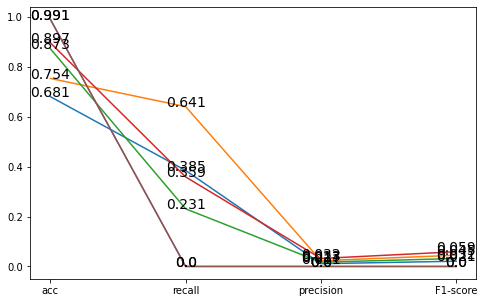

In [39]:
pred_xgb = model_xgb.predict(X_test_imputed)
result_view('XGBoost', pred_xgb, y_test)

### 7. CatBoost

In [40]:
start = time.time()

In [41]:
cat = CatBoostClassifier(learning_rate=0.03,
                        iterations=2000,
                        random_state=42)

In [42]:
start = time.time()

train_dataset = Pool(data=X_train_smote, label = y_train_smote)
eval_dataset = Pool(data=X_val_imputed, label = y_val)

cat.fit(train_dataset, eval_set=eval_dataset, early_stopping_rounds = 30)
(time.time()-start)/60

0:	learn: 0.6489876	test: 0.6615285	best: 0.6615285 (0)	total: 59ms	remaining: 1m 57s
1:	learn: 0.6163081	test: 0.6377387	best: 0.6377387 (1)	total: 66.9ms	remaining: 1m 6s
2:	learn: 0.5793501	test: 0.6079979	best: 0.6079979 (2)	total: 74.2ms	remaining: 49.4s
3:	learn: 0.5538798	test: 0.5831402	best: 0.5831402 (3)	total: 81.3ms	remaining: 40.6s
4:	learn: 0.5259952	test: 0.5594029	best: 0.5594029 (4)	total: 88.3ms	remaining: 35.3s
5:	learn: 0.4964681	test: 0.5391796	best: 0.5391796 (5)	total: 95.3ms	remaining: 31.7s
6:	learn: 0.4698731	test: 0.5164796	best: 0.5164796 (6)	total: 102ms	remaining: 29.1s
7:	learn: 0.4443534	test: 0.4997256	best: 0.4997256 (7)	total: 110ms	remaining: 27.3s
8:	learn: 0.4216703	test: 0.4832913	best: 0.4832913 (8)	total: 117ms	remaining: 25.9s
9:	learn: 0.4038517	test: 0.4674285	best: 0.4674285 (9)	total: 124ms	remaining: 24.7s
10:	learn: 0.3872016	test: 0.4525756	best: 0.4525756 (10)	total: 132ms	remaining: 23.8s
11:	learn: 0.3699370	test: 0.4395677	best: 0.43

111:	learn: 0.0352687	test: 0.0617862	best: 0.0617862 (111)	total: 871ms	remaining: 14.7s
112:	learn: 0.0351015	test: 0.0615407	best: 0.0615407 (112)	total: 878ms	remaining: 14.7s
113:	learn: 0.0348632	test: 0.0611777	best: 0.0611777 (113)	total: 885ms	remaining: 14.6s
114:	learn: 0.0346652	test: 0.0608625	best: 0.0608625 (114)	total: 892ms	remaining: 14.6s
115:	learn: 0.0344423	test: 0.0605491	best: 0.0605491 (115)	total: 899ms	remaining: 14.6s
116:	learn: 0.0341994	test: 0.0602475	best: 0.0602475 (116)	total: 907ms	remaining: 14.6s
117:	learn: 0.0340062	test: 0.0600186	best: 0.0600186 (117)	total: 913ms	remaining: 14.6s
118:	learn: 0.0337275	test: 0.0598267	best: 0.0598267 (118)	total: 921ms	remaining: 14.6s
119:	learn: 0.0335673	test: 0.0595977	best: 0.0595977 (119)	total: 927ms	remaining: 14.5s
120:	learn: 0.0333885	test: 0.0593847	best: 0.0593847 (120)	total: 934ms	remaining: 14.5s
121:	learn: 0.0331946	test: 0.0591181	best: 0.0591181 (121)	total: 941ms	remaining: 14.5s
122:	learn

226:	learn: 0.0228928	test: 0.0514614	best: 0.0514609 (224)	total: 1.68s	remaining: 13.1s
227:	learn: 0.0228676	test: 0.0514444	best: 0.0514444 (227)	total: 1.69s	remaining: 13.1s
228:	learn: 0.0228229	test: 0.0514512	best: 0.0514444 (227)	total: 1.7s	remaining: 13.1s
229:	learn: 0.0227953	test: 0.0514480	best: 0.0514444 (227)	total: 1.7s	remaining: 13.1s
230:	learn: 0.0227723	test: 0.0514574	best: 0.0514444 (227)	total: 1.71s	remaining: 13.1s
231:	learn: 0.0227215	test: 0.0514197	best: 0.0514197 (231)	total: 1.72s	remaining: 13.1s
232:	learn: 0.0226654	test: 0.0513944	best: 0.0513944 (232)	total: 1.72s	remaining: 13.1s
233:	learn: 0.0226270	test: 0.0513953	best: 0.0513944 (232)	total: 1.73s	remaining: 13.1s
234:	learn: 0.0225954	test: 0.0514175	best: 0.0513944 (232)	total: 1.74s	remaining: 13s
235:	learn: 0.0225534	test: 0.0514168	best: 0.0513944 (232)	total: 1.74s	remaining: 13s
236:	learn: 0.0225026	test: 0.0513989	best: 0.0513944 (232)	total: 1.75s	remaining: 13s
237:	learn: 0.0224

318:	learn: 0.0191880	test: 0.0504084	best: 0.0503918 (316)	total: 2.29s	remaining: 12.1s
319:	learn: 0.0191498	test: 0.0504023	best: 0.0503918 (316)	total: 2.29s	remaining: 12.1s
320:	learn: 0.0191195	test: 0.0504198	best: 0.0503918 (316)	total: 2.3s	remaining: 12s
321:	learn: 0.0190693	test: 0.0503742	best: 0.0503742 (321)	total: 2.31s	remaining: 12s
322:	learn: 0.0190208	test: 0.0504179	best: 0.0503742 (321)	total: 2.31s	remaining: 12s
323:	learn: 0.0189972	test: 0.0504333	best: 0.0503742 (321)	total: 2.32s	remaining: 12s
324:	learn: 0.0189554	test: 0.0503994	best: 0.0503742 (321)	total: 2.33s	remaining: 12s
325:	learn: 0.0189138	test: 0.0504044	best: 0.0503742 (321)	total: 2.34s	remaining: 12s
326:	learn: 0.0188838	test: 0.0503914	best: 0.0503742 (321)	total: 2.35s	remaining: 12s
327:	learn: 0.0188289	test: 0.0503850	best: 0.0503742 (321)	total: 2.35s	remaining: 12s
328:	learn: 0.0187715	test: 0.0503775	best: 0.0503742 (321)	total: 2.36s	remaining: 12s
329:	learn: 0.0187374	test: 0

0.045876018206278485

                       acc  recall  precision  F1-score
SVM                  0.681   0.385      0.011     0.021
Logistic Regression  0.754   0.641      0.023     0.045
KNN                  0.873   0.231      0.017     0.032
Decision Tree        0.897   0.359      0.032     0.059
Random Forest        0.991   0.000      0.000     0.000
XGBoost              0.991   0.000      0.000     0.000
Cat Boost            0.991   0.000      0.000     0.000


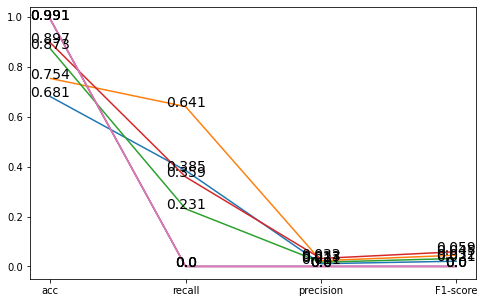

In [43]:
pred_cat = cat.predict(X_test_imputed)
result_view('Cat Boost', pred_cat, y_test)

### 8. DNN

In [52]:
dnn = tf.keras.models.Sequential([
    Dense(512, activation ='relu', input_shape = (84,)),
    Dense(256, activation ='relu'),
    Dense(128, activation ='relu'),
    Dense(64, activation ='relu'),
    Dense(32, activation ='relu'),
    Dense(2, activation ='softmax'),
])

In [49]:
dnn.compile(optimizer = 'adam',
           loss = 'sparse_categorical_crossentropy',
           metrics=['acc'])

In [50]:
checkpoint_path = 'my_checkpoint.ckpt'
check_point = ModelCheckpoint(filepath = checkpoint_path,
                              save_weights_only = True,
                              save_best_only = True,
                              monitor = 'vale_loss',
                              verbose = 1)

In [51]:
history = dnn.fit(x=X_train_smote, y = y_train_smote,
              epochs = 30, batch_size = 20,
              validation_data = (X_val_imputed, y_val), verbose = 1,
              callbacks = [check_point])

Epoch 1/30
1288/1288 [==============================] - 26s 18ms/step - loss: 0.5830 - acc: 0.7103 - val_loss: 0.2277 - val_acc: 0.9079
Epoch 2/30
1288/1288 [==============================] - 22s 17ms/step - loss: 0.3668 - acc: 0.8373 - val_loss: 0.2150 - val_acc: 0.9069
Epoch 3/30
1288/1288 [==============================] - 23s 18ms/step - loss: 0.2826 - acc: 0.8815 - val_loss: 0.3585 - val_acc: 0.8241
Epoch 4/30
1288/1288 [==============================] - 23s 18ms/step - loss: 0.2282 - acc: 0.9092 - val_loss: 0.2574 - val_acc: 0.8959
Epoch 5/30
1288/1288 [==============================] - 23s 18ms/step - loss: 0.1875 - acc: 0.9283 - val_loss: 0.2313 - val_acc: 0.9430
Epoch 6/30
1288/1288 [==============================] - 23s 18ms/step - loss: 0.1606 - acc: 0.9412 - val_loss: 0.3032 - val_acc: 0.9012
Epoch 7/30
1288/1288 [==============================] - 22s 17ms/step - loss: 0.1426 - acc: 0.9490 - val_loss: 0.2588 - val_acc: 0.9215
Epoch 8/30
1288/1288 [==========================

1288/1288 [==============================] - 22s 17ms/step - loss: 0.0395 - acc: 0.9873 - val_loss: 0.2864 - val_acc: 0.9732
Epoch 29/30
1288/1288 [==============================] - 23s 18ms/step - loss: 0.0400 - acc: 0.9878 - val_loss: 0.3308 - val_acc: 0.9661
Epoch 30/30
1288/1288 [==============================] - 22s 17ms/step - loss: 0.0359 - acc: 0.9881 - val_loss: 0.3901 - val_acc: 0.9321


In [ ]:
plt.figure(figsize= (12, 9))
plt.plot(np.arange(1, 21), history.history['loss'])
plt.plot(np.arange(1, 21), history.history['val_loss'])
plt.title('Loss / Val Loss', fontsize = 20)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'], fontsize=15)
plt.show()

In [ ]:
plt.figure(figsize= (12, 9))
plt.plot(np.arange(1, 21), history.history['acc'])
plt.plot(np.arange(1, 21), history.history['val_acc'])
plt.title('Acc / Val Acc', fontsize = 20)
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend(['acc', 'val_acc'], fontsize=15)
plt.show()

-------

In [267]:
initializer = tf.keras.initializers.GlorotUniform(seed=42)
dnn = Sequential()
dnn.add(Dense(512, activation ='relu', input_shape = (85,), kernel_initializer = initializer))
# dnn.add(Dropout(0.2))
dnn.add(Dense(256, activation = 'relu'))
# dnn.add(Dropout(0.2))
dnn.add(Dense(128, activation = 'relu'))
dnn.add(Dense(64, activation = 'relu'))
dnn.add(Dense(32, activation = 'relu'))
dnn.add(Dense(3, activation = 'softmax')) 
dnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 512)               44032     
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 3)                 99        
                                                                 
Total params: 218,691
Trainable params: 218,691
Non-tr

In [268]:
dnn.compile(optimizer = 'adam',
           loss = 'sparse_categorical_crossentropy',
           metrics=['accuracy'])

In [270]:
early_stop = EarlyStopping(monitor='val_loss', mode = 'min',
                          verbose=1, patience=5)

check_point = ModelCheckpoint('best_model.h5', verbose=1,
                             monitor='val_loss', mode='min', save_best_only=True)


hist = dnn.fit(x=X_train_smote, y = y_train_smote,
              epochs = 50, batch_size=20,
              validation_data = (X_val_imputed, y_val), verbose = 1,
              callbacks = [early_stop, check_point])

Epoch 1/50
1287/1288 [============================>.] - ETA: 0s - loss: 0.3783 - accuracy: 0.8504
Epoch 1: val_loss improved from inf to 0.08017, saving model to best_model.h5
1288/1288 [==============================] - 20s 15ms/step - loss: 0.3782 - accuracy: 0.8504 - val_loss: 0.0802 - val_accuracy: 0.9866
Epoch 2/50
1286/1288 [============================>.] - ETA: 0s - loss: 0.1145 - accuracy: 0.9690
Epoch 2: val_loss did not improve from 0.08017
1288/1288 [==============================] - 20s 15ms/step - loss: 0.1146 - accuracy: 0.9689 - val_loss: 0.1705 - val_accuracy: 0.9384
Epoch 3/50
1287/1288 [============================>.] - ETA: 0s - loss: 0.0328 - accuracy: 0.9883
Epoch 3: val_loss improved from 0.08017 to 0.02944, saving model to best_model.h5
1288/1288 [==============================] - 20s 16ms/step - loss: 0.0329 - accuracy: 0.9883 - val_loss: 0.0294 - val_accuracy: 0.9956
Epoch 4/50
1284/1288 [============================>.] - ETA: 0s - loss: 0.0322 - accuracy: 0.9

-----

                       acc  recall  precision  F1-score
DNN                  0.260   0.821      0.010     0.020
SVM                  0.681   0.385      0.011     0.021
Logistic Regression  0.754   0.641      0.023     0.045
KNN                  0.873   0.231      0.017     0.032
Decision Tree        0.897   0.359      0.032     0.059
Random Forest        0.991   0.000      0.000     0.000
XGBoost              0.991   0.000      0.000     0.000
Cat Boost            0.991   0.000      0.000     0.000


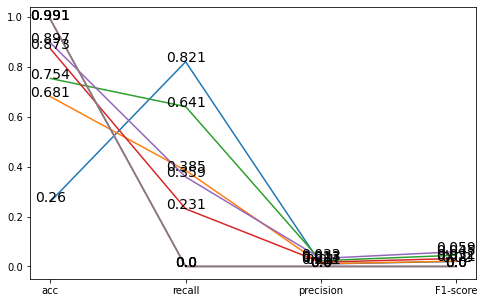

In [53]:
pred_dnn = dnn.predict(X_test_imputed)
pred_dnn = np.where(pred_dnn[:, 0] > pred_dnn[:, 1], 0, 1)
result_view('DNN', pred_dnn, y_test)

----

In [247]:
def show_confusion_matrix(labels, y_true, y_pred, title):
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt = 'd', xticklabels = labels, yticklabels=labels,
               cmap=plt.cm.Blues, linecolor='black')
    plt.text(1,2.3, 'Predicted', size=15, ha='center')
    plt.text(-0.3,1, 'True', rotation=90, size=15, ha='center')
    plt.title(title)
    plt.show

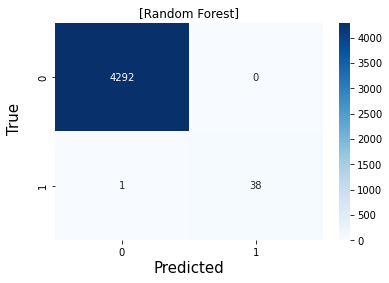

In [255]:
labels= [0, 1]
# show_confusion_matrix(labels, y_test, pred_cat, '[CatBoost]')
show_confusion_matrix(labels, y_test, pred_rf, '[Random Forest]')

In [263]:
def plot_multicalss_roc(y_pred, y_true, y_label):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    y_test_dummies = pd.get_dummies(y_true, drop_first=False).values
    
    for i in range(len(y_label)):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
        fig, ax = plt.subplots(figsize=(17, 10))
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('Receiver operating characteristic example')
        for i in range(len(y_label)):
            ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %s ' % (roc_auc[i], y_lable[i]))
            ax.legend(loc = 'best')
            ax.grid(alpha=.4)
            sns.despine()
            plt.show()


[1] 재발 위험도 분석
- 전체 학습으로 재발율 1로 예측한 피험자의 확률값을 가지고 위험도를 나눈다.
- 예후인자

[2] 재발시기 예측
- 재발시기를 label로 시기를 예측하기(재발피험자 대상)
- 예후인자 

[3] 건강행태 예후인자
- 건강행태 변수들로 피험자의 유의미한 지표 추출

[4] 원발부위코드로 암 위치 판정
-

### SHAP

In [320]:
explainer = shap.Explainer(model_xgb)
# shpe_values = explainer.shape_values(X_test_imputed)

In [321]:
explainer

In [296]:
model_lgb = lgb.LGBMClassifier()
model_lgb.fit(X_train_smote, y_train_smote)

[LightGBM] [Info] Number of positive: 12876, number of negative: 12876
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20947
[LightGBM] [Info] Number of data points in the train set: 25752, number of used features: 84
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

LGBMClassifier()

In [301]:
y_pred_prob = model_lgb.predict_proba(X_test_imputed)[:, 1]
y_pred = model_lgb.predict(X_test_imputed)

In [304]:
val = sklearn.metrics.roc_auc_score(y_test, y_pred_prob)
print(f"auc-roc 스코어 : {val}")

auc-roc 스코어 : 1.0


In [305]:
display(pd.crosstab(y_test, y_pred))

col_0,0,1
LABEL,,
0,4292,0
1,0,39


----

In [28]:
import lightgbm as lgb
from math import sqrt
from sklearn.metrics import mean_squared_error

In [27]:
model_shap = RandomForestClassifier(n_estimators=100, random_state=42)
model_shap.fit(X_train_smote, y_train_smote)

RandomForestClassifier(random_state=42)

In [31]:
explainer = shap.TreeExplainer(model_shap)

In [33]:
shap_values = explainer.shap_values(X_test_imputed)

In [52]:
shap_values

[array([[1.52367872e-02, 2.20177137e-04, 1.15838073e-02, ...,
         7.98103628e-04, 1.49798738e-04, 1.90979007e-04],
        [6.60231706e-03, 6.69623553e-04, 3.72097646e-03, ...,
         1.12584383e-03, 1.68544723e-04, 1.87922814e-04],
        [8.91342337e-03, 2.71087457e-03, 2.99081216e-02, ...,
         1.05961805e-03, 8.14700728e-04, 3.28769646e-04],
        ...,
        [2.02471355e-02, 1.66868365e-03, 2.74038518e-02, ...,
         6.03153308e-04, 2.59608384e-04, 1.31552599e-04],
        [1.42887252e-02, 2.65027260e-03, 4.09545846e-03, ...,
         5.73540393e-04, 1.85697539e-04, 7.51801706e-05],
        [1.88279312e-02, 1.00773411e-03, 3.22874385e-02, ...,
         9.29955055e-04, 2.12874124e-04, 1.07374432e-04]]),
 array([[-1.52367872e-02, -2.20177137e-04, -1.15838073e-02, ...,
         -7.98103628e-04, -1.49798738e-04, -1.90979007e-04],
        [-6.60231706e-03, -6.69623553e-04, -3.72097646e-03, ...,
         -1.12584383e-03, -1.68544723e-04, -1.87922814e-04],
        [-8.9

In [53]:
X_test_imputed

,SEX,AGE,CL_CD,SOPR_Y_CNT,HGHT,WGHT,BMI,WSTC,BP_SYS,BP_DIA,URN_PROT,HGB,FBS,SGOT,SGPT,GGT,TG,HDL,LDL,TOT_CHOL,CRTN,GFR,TCODE,MCODE_GRP,GRADE,T_SIZE,EXT,LNPOS,METS,SSF1,SSF8,SSF9,AJCC6_T,AJCC6_TEVAL,AJCC6_N,AJCC6_NEVAL,AJCC6_M,AJCC6_MEVAL,AJCC6_STAGE,SS2000,WT_LSS,Q_SMK_YN,Q_DAILY_DRK,Q_DRK_RISK,Q_PA_WGT_AVG,Q_FHX_ETC,Q_PHX_YN,Q_PHX_DX_STK,Q_PHX_DX_HTDZ,Q_PHX_DX_HTN,Q_PHX_DX_DM,Q_PHX_DX_PTB,Q_PHX_DX_DLD,Q_PHX_DX_ETC,Q_PHX_TX_STK,Q_PHX_TX_HTDZ,Q_PHX_TX_HTN,Q_PHX_TX_DM,Q_PHX_TX_DLD,Q_PHX_TX_ETC,WT_LSS_AMT,QC_PFHX_CST_YN,QC_PFHX_CST_I,QC_PFHX_CBR_YN,QC_PFHX_CBR_I,QC_PFHX_CCR_YN,QC_PFHX_CCR_I,QC_PFHX_CLV_YN,QC_PFHX_CLV_I,QC_PFHX_CCX_YN,QC_PFHX_CCX_I,QC_PFHX_ETC_YN,QC_PFHX_ETC_I,QC_PHX_PU_YN,QC_PHX_ATGS_YN,QC_PHX_INMT_YN,QC_PHX_GPO_YN,QC_PHX_ST_ETC,QC_PHX_CRA_YN,QC_PHX_CD_YN,QC_PHX_HMR_YN,QC_PHX_LV_YN,QC_PHX_CHB_YN,QC_PHX_CHC_YN
0,2.0,69.0,1.0,2.0,150.0,60.0,27.0,80.0,130.0,80.0,1.0,10.7,90.0,19.0,12.0,11.0,177.0,42.0,128.0,206.0,1.00,58.0,1.0,1.0,1.0,19.0,200.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.20,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.5,1.0,1.0,1.0,0.0,5.0,1.0,1.5,0.0,1.5,0.0,2.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,1.5,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,65.0,1.0,2.0,160.0,70.0,28.0,90.0,130.0,80.0,1.0,17.7,145.0,54.0,49.0,158.0,522.0,54.0,71.0,149.0,0.80,105.0,6.0,1.0,0.0,14.0,160.0,0.0,0.0,0.0,0.0,0.5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,16.0,0.0,0.00,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,2.5,0.0,1.5,0.0,1.0,0.0,1.5,0.0,1.0,0.0,1.5,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,72.0,0.0,3.0,150.0,60.0,24.0,80.0,188.0,97.0,5.0,16.0,171.0,27.0,22.0,224.0,234.0,79.0,97.0,223.0,2.30,29.0,10.0,1.0,0.0,55.0,200.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,3.0,16.0,0.0,0.00,0.0,2.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,0.0,1.0,0.0,1.0,0.5,1.5,0.0,1.0,0.0,1.5,0.0,1.0,1.0,1.0,1.0,1.0,1.5,1.5,1.0,1.0,1.0,1.0,1.0
3,2.0,80.0,1.0,1.0,150.0,60.0,25.0,80.0,143.0,74.0,1.0,12.6,86.0,18.0,19.0,25.0,150.0,52.0,127.0,209.0,0.80,55.0,1.0,1.0,0.0,25.0,160.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,2.50,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,2.5,1.0,2.0,0.0,1.0,0.0,1.5,0.0,1.0,0.0,1.5,0.0,1.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,71.0,1.0,2.0,160.0,60.0,24.0,90.0,128.0,83.0,1.0,16.8,90.0,23.0,21.0,30.0,192.0,47.0,123.0,208.0,1.20,63.0,10.0,1.0,1.0,32.0,470.0,0.0,0.0,0.0,0.0,0.5,2.0,0.0,1.0,0.0,0.0,0.0,4.0,3.0,1.0,2.0,0.0,0.0,0.00,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.5,1.0,1.0,1.0,0.5,1.0,8.5,1.0,2.0,0.0,1.5,0.0,1.5,0.0,1.0,0.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4326,2.0,75.0,0.0,3.0,155.0,55.0,22.5,80.0,158.0,86.0,1.0,13.4,90.5,21.5,15.5,15.5,170.5,54.0,78.5,166.5,0.95,72.0,6.0,1.0,1.0,39.0,425.0,0.5,1.0,1.0,0.5,0.5,2.0,0.0,1.0,0.0,1.0,0.0,7.0,0.0,1.5,1.5,0.0,0.0,17.75,0.0,2.0,0.0,0.0,0.5,0.0,0.0,0.0,0.5,0.5,1.0,1.0,1.0,1.0,1.0,4.5,0.0,1.0,0.0,1.5,0.0,1.5,0.0,1.5,0.5,1.0,0.0,1.5,1.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4327,2.0,77.0,1.0,1.0,150.0,50.0,22.0,80.0,128.0,86.0,1.0,11.1,136.0,15.0,10.0,20.0,177.0,35.0,105.0,175.0,0.90,65.0,10.0,1.0,1.0,38.0,160.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,3.0,4.0,1.0,1.0,0.0,0.0,1.20,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,2.5,0.0,1.5,0.0,1.5,0.0,1.5,0.0,1.0,0.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4328,2.0,73.0,0.0,3.0,150.0,50.0,25.0,70.0,137.0,89.0,1.0,11.8,88.0,30.0,23.0,12.0,137.0,61.0,138.0,227.0,0.70,87.0,10.0,1.0,0.0,11.0,160.0,0.5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.20,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.

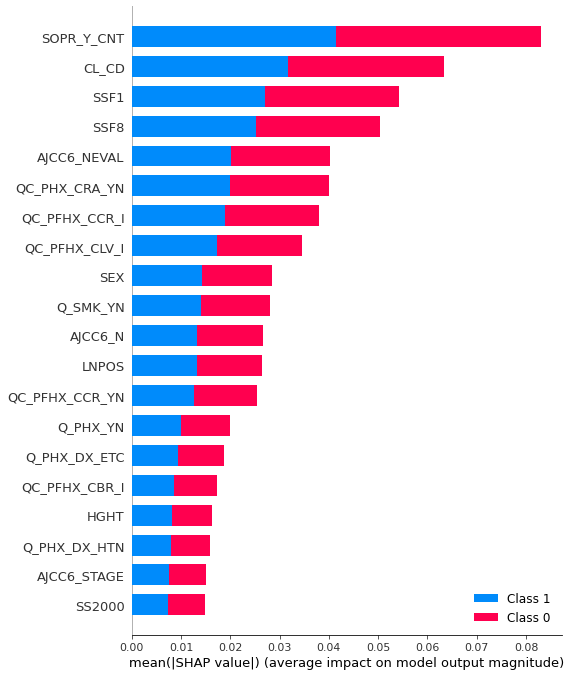

In [43]:
shap.summary_plot(shap_values, X_test_imputed)

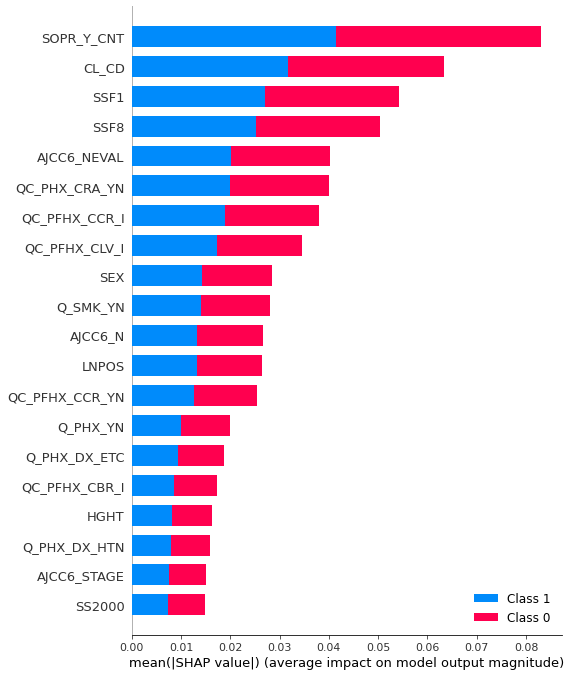

In [34]:
shap.summary_plot(shap_values, X_test_imputed, feature_names=X_train_smote.columns)

In [54]:
y_pred = model_shap.predict(X_test_imputed)

acc = accuracy_score(y_test, y_pred)
print(f'정확도: {acc}')

정확도: 0.9909951512352805
